# 神经网络之预测共享单车使用情况



### 整体流程

1. 对数据进行预处理
    + 导入数据
    + 处理Dummies(哑变量)
    + 分割数据成train set, test set, validation set
2. 建立神经网络
    + 该神经网络只有一个隐层
    + 利用反向传播进行权重更新
3. 测试用例
    + 确保神经网络编写正确
4. 训练网络
    + 调整参数：迭代次数， 学习速率，隐层个数

In [1]:
#显示 matplotlib 包生成的图形
%matplotlib inline   
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1 预处理

### 导入数据 

  ##### hours .csv:共享单车以小时为单位进行汇总。记录：17379小时
  ##### day.csv:共享单车计数每天汇总。记录：731天
 ##### 数据集各属性 
    - instant: 记录索引
	- dteday : 日期
	- season : 季节（1：春天，2：夏天，3：秋天，4：冬天）
	- yr : 年 (0: 2011, 1:2012)
	- mnth : 月 ( 1 to 12)
	- hr : 小时 (0 to 23)
	- holiday : 天气日是否是假日
	- weekday : 周几？
	- workingday : 如果一天既不是周末也不是假日是1，否则是0。
	+ weathersit : 
		- 1: 晴朗，少云，多云
		- 2: 雾+云，雾+碎云，雾+少云，雾
		- 3: 小雪，小雨+雷雨+散云，小雨+散云
		- 4: 大雨+冰盘+雷雨+雾，雪+雾
	- temp : 摄氏的标准化温度。值被划分为41（max）
	- atemp: 摄氏的标准化感觉温度。值被划分为50（max）
	- hum:归一化湿度值被划分为100（max）
	- windspeed: 归一化风速值被划分为67（max）
	- casual: 临时用户数
	- registered: 注册用户数
	- cnt: 租赁和注册的租赁自行车总数



In [2]:
data_path = 'dataset/day.csv'
rides = pd.read_csv(data_path)
rides.head(10)

instant     dteday    weekday   mnth   cnt  season  weathersit  temp  \
0        1   2019/3/1     Friday  March   776       1           3  0.42   
1        2   2019/3/2   Saturday  March   848       1           3  0.42   
2        3   2019/3/3     Sunday  March   943       1           2  0.40   
3        4   2019/3/4     Monday  March   886       1           2  0.40   
4        5   2019/3/5    Tuesday  March   922       1           2  0.40   
5        6   2019/3/6  Wednesday  March   782       1           2  0.46   
6        7   2019/3/7   Thursday  March   866       1           2  0.46   
7        8   2019/3/8     Friday  March   917       1           2  0.44   
8        9   2019/3/9   Saturday  March   952       1           2  0.42   
9       10  2019/3/10     Sunday  March  1052       1           2  0.46   

    atemp   hum  windspeed  registered  year  casual  
0  0.4242  0.88   0.208317         776     0       2  
1  0.4242  0.88   0.195904         848     0       2  
2  0.4091  0.87   0.353242         943     0       1  
3  0.4091  0.87   0.171970         886     0       1  
4  0.4091  0.94   0.246600         922     0       1  
5  0.4545  0.88   0.158330         782     0       1  
6  0.4545  0.88   0.129796         866     0       2  
7  0.4394  0.94   0.293850         917     0       3  
8  0.4242  1.00   0.113837         952     0       1  
9  0.4545  0.94   0.123300        1052     0       2

### 绘制某些数据

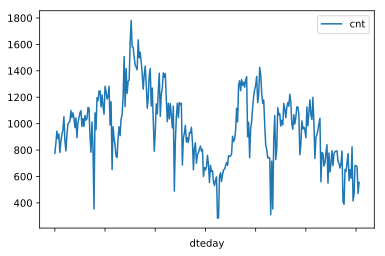

In [3]:
rides[:].plot(x='dteday', y='cnt')
#打出前20天20*24小时的数据

### 处理哑变量 

1. 虚拟变量(dummy variables)，也叫哑变量和离散特征编码，可用来表示分类变量、非数量因素可能产生的影响。

离散特征的编码分为两种情况：

(1)离散特征的取值之间没有大小的意义，比如color：[red,blue],那么就使用one-hot编码

(2)离散特征的取值有大小的意义，比如size:[X,XL,XXL],那么就使用数值的映射{X:1,XL:2,XXL:3}

常用于统计建模或机器学习的转换方式是：将分类变量（categorical variable）转换为“哑变量矩

阵”（dummy matrix）或“指标矩阵”（indicator matrix）。如果DataFrame的某一列中含有k个不同的

值，则可以派生出一个k列矩阵或DataFrame（其值全为1和0）。使用pandas可以很方便的对离散型特征进行one-hot编码

2.  pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False,keys=None, levels=None, names=None, verify_integrity=False,copy=True)
          
    - objs：Series，DataFrame或Panel对象的序列或映射。如果传递了dict，则排序的键将用作键参数，除非它被传递，在这种情况下，将选择值。任何无对象将被静默删除，除非它们都是无，在这种情况下将引发一个ValueError。
    - axis：{0,1，...}，默认为0。沿着连接的轴。
    - join：{'inner'，'outer'}，默认为“outer”。如何处理其他轴上的索引。outer为联合和inner为交集。
    - ignore_index：boolean，default False。如果为True，请不要使用并置轴上的索引值。结果轴将被标记为0，...，n-1。如果要连接其中并置轴没有有意义的索引信息的对象，这将非常有用。注意，其他轴上的索引值在连接中仍然受到尊重。
    - join_axes：Index对象列表。用于其他n-1轴的特定索引，而不是执行内部/外部设置逻辑。
    - keys：序列，默认值无。使用传递的键作为最外层构建层次索引。如果为多索引，应该使用元组。
    - levels：序列列表，默认值无。用于构建MultiIndex的特定级别（唯一值）。否则，它们将从键推断。
    - names：list，default无。结果层次索引中的级别的名称。
    - verify_integrity：boolean，default False。检查新连接的轴是否包含重复项。这相对于实际的数据串联可能是非常昂贵的。
    - copy：boolean，default True。如果为False，请勿不必要地复制数据。


In [4]:
dummies_fields = ['season', 'dteday', 'mnth', 'weekday', 'weathersit']

for each in dummies_fields:
    dummies = pd.get_dummies( rides.loc[:, each], prefix=each )
    rides = pd.concat( [rides, dummies], axis=1 )
rides.head(3)    

instant    dteday   weekday   mnth  cnt  season  weathersit  temp   atemp  \
0        1  2019/3/1    Friday  March  776       1           3  0.42  0.4242   
1        2  2019/3/2  Saturday  March  848       1           3  0.42  0.4242   
2        3  2019/3/3    Sunday  March  943       1           2  0.40  0.4091   

    hum      ...       weekday_Friday  weekday_Monday  weekday_Saturday  \
0  0.88      ...                    1               0                 0   
1  0.88      ...                    0               0                 1   
2  0.87      ...                    0               0                 0   

   weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
0               0                 0                0                  0   
1               0                 0                0                  0   
2               1                 0                0                  0   

   weathersit_1  weathersit_2  weathersit_3  
0             0             0             1  
1             0             0             1  
2             0             1             0  

[3 rows x 342 columns]

#### drop()方法：删除以下列

In [5]:
drop_fields = [ 'season',  'mnth', 'weekday', 'weathersit', 'instant', 'dteday', 'atemp' ]
data = rides.drop(drop_fields, axis=1)
data.head(3)

cnt  temp   hum  windspeed  registered  year  casual  season_1  season_2  \
0  776  0.42  0.88   0.208317         776     0       2         1         0   
1  848  0.42  0.88   0.195904         848     0       2         1         0   
2  943  0.40  0.87   0.353242         943     0       1         1         0   

   season_3      ...       weekday_Friday  weekday_Monday  weekday_Saturday  \
0         0      ...                    1               0                 0   
1         0      ...                    0               0                 1   
2         0      ...                    0               0                 0   

   weekday_Sunday  weekday_Thursday  weekday_Tuesday  weekday_Wednesday  \
0               0                 0                0                  0   
1               0                 0                0                  0   
2               1                 0                0                  0   

   weathersit_1  weathersit_2  weathersit_3  
0             0             0             1  
1             0             0             1  
2             0             1             0  

[3 rows x 335 columns]

### 标准化数据

需要进行标准化的数据：‘temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt'  

+ 将mean, std保存，以便后来数据的恢复
+mean()求均值
+std（）求标准差

#### 标准差也成为标准偏差,表示数据的离散程度,和标准差大小成反比
 data.mean(axis=0) 输出矩阵为一行,求每列的平均值,同理data.mean(axis=1) 输出矩阵为一列,求每行的平均值
 data.std(axis=0) 输出矩阵为一列,求每列的标准差,同理data.std(axis=1) 输出矩阵为一列,求每行的标准差


In [6]:
standard_field = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
scaled_feature = {}
for each in standard_field:
    mean, std = data[each].mean(), data[each].std()
    scaled_feature[each] = [mean, std]  #记录原始数据的均值和标准差
    data.loc[:, each] = (data.loc[:,each] - mean) / std
    
data.head()

cnt      temp       hum  windspeed  registered  year    casual  \
0 -0.720220  2.983771  2.151697   0.194910   -0.720220     0  1.041451   
1 -0.452304  2.983771  2.151697   0.033261   -0.452304     0  1.041451   
2 -0.098804  2.715883  2.088783   2.082206   -0.098804     0 -0.737207   
3 -0.310904  2.715883  2.088783  -0.278421   -0.310904     0 -0.737207   
4 -0.176946  2.715883  2.529180   0.693453   -0.176946     0 -0.737207   

   season_1  season_2  season_3      ...       weekday_Friday  weekday_Monday  \
0         1         0         0      ...                    1               0   
1         1         0         0      ...                    0               0   
2         1         0         0      ...                    0               0   
3         1         0         0      ...                    0               1   
4         1         0         0      ...                    0               0   

   weekday_Saturday  weekday_Sunday  weekday_Thursday  weekday_Tuesday  \
0                 0               0                 0                0   
1                 1               0                 0                0   
2                 0               1                 0                0   
3                 0               0                 0                0   
4                 0               0                 0                1   

   weekday_Wednesday  weathersit_1  weathersit_2  weathersit_3  
0                  0             0             0             1  
1                  0             0             0             1  
2                  0             0             1             0  
3                  0             0             1             0  
4                  0             0             1             0  

[5 rows x 335 columns]

### 查看处理好的数据

In [25]:
#print(data.dtypes)#获取全部列的类型
#print(data.shape)#获取维度

### 分割数据 

In [7]:
#将最后21*24=504 行数据赋给test_data
# test_data = data[-31:]
test_data = data[-91:-61]


#去掉最后21*24=504 行数据，其他赋给data，用于训练模型
# data = data[:-31]
data = data[:-91]


# 将数据分成特征和目标
target_fields = ['cnt', 'casual', 'registered']

#特征
features = data.drop( target_fields, axis=1 )
features.head()

temp       hum  windspeed  year  season_1  season_2  season_3  \
0  2.983771  2.151697   0.194910     0         1         0         0   
1  2.983771  2.151697   0.033261     0         1         0         0   
2  2.715883  2.088783   2.082206     0         1         0         0   
3  2.715883  2.088783  -0.278421     0         1         0         0   
4  2.715883  2.529180   0.693453     0         1         0         0   

   season_4  dteday_2019/10/1  dteday_2019/10/10      ...       \
0         0                 0                  0      ...        
1         0                 0                  0      ...        
2         0                 0                  0      ...        
3         0                 0                  0      ...        
4         0                 0                  0      ...        

   weekday_Friday  weekday_Monday  weekday_Saturday  weekday_Sunday  \
0               1               0                 0               0   
1               0               0                 1               0   
2               0               0                 0               1   
3               0               1                 0               0   
4               0               0                 0               0   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  weathersit_1  \
0                 0                0                  0             0   
1                 0                0                  0             0   
2                 0                0                  0             0   
3                 0                0                  0             0   
4                 0                1                  0             0   

   weathersit_2  weathersit_3  
0             0             1  
1             0             1  
2             1             0  
3             1             0  
4             1             0  

[5 rows x 332 columns]

In [8]:
#目标
targets = data.loc[:, target_fields]
targets.head()




#作为测试集

#最后的504行数据中，test_data有504行数据， 分成目标和特征
test_features = test_data.drop( target_fields, axis=1 )
test_targets = test_data.loc[:, target_fields]

#将前部分数据分为训练集和验证集
train_features, train_targets = features[:-60], targets[:-60]
val_features, val_targets = features[-60:], targets[-60:]

In [9]:
print('ok')

ok


## Step 2 建立神经网络 

    + Python的类的方法和普通的函数有一个很明显的区别，在类的方法必须有个额外的第一个参数(self)，但在调用这个方法的时候不必为这个参数赋值
    
    + 初始化权重方法：高斯分布。对应于numpy中：numpy.random.normal(loc=0.0, scale=1.0, size=None)，我们更经常会用到的np.random.randn(size)所谓标准正态分布（μ=0,σ=1μ=0,σ=1），对应于np.random.normal(loc=0, scale=1, size)。
      参数的意义为：
         loc：float  此概率分布的均值（对应着整个分布的中心centre）
         scale：float  此概率分布的标准差（对应于分布的宽度，scale越大越矮胖，scale越小，越瘦高）
         size：int or tuple of ints  输出的shape，默认为None，只输出一个值




In [10]:
class NeuralNetwork(object):
    def __init__( self, input_nodes, hidden_nodes, output_nodes, learning_rate ):
        # 设置输入、隐藏和输出层中的节点数、学习率
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        
        # 初始化权重：高斯分布
        self.weights_input_to_hidden = np.random.normal( 0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes) )
        self.weights_hidden_to_output = np.random.normal( 0.0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.output_nodes) )
        
        # 激活函数
        self.activation_function = lambda x : 1 / ( 1 + np.exp(-x) )
        
    def train(self, features, targets):
        #训练模型
        n_record = features.shape[0]  #features.shape[0]=15867
        delta_weights_i_h = np.zeros( self.weights_input_to_hidden.shape )
        delta_weights_h_o = np.zeros( self.weights_hidden_to_output.shape )
        
        for X, y in zip( features, targets ):
            
            #dot()返回的是两个数组的点积(dot product)
            #对于二维数组来说，dot()计算的结果就相当于矩阵乘法。
            #对于一维数组，它计算的是两个向量的点积。
            #对于N维数组，它是a的最后一维和b的倒数第二维和的积：dot(a, b)[i,j,k,m] = sum(a[i,j,:] * b[k,:,m])
            
            hidden_inputs = np.dot( X, self.weights_input_to_hidden )
            hidden_outputs = self.activation_function( hidden_inputs )
        
            final_inputs = np.dot( hidden_outputs, self.weights_hidden_to_output )
            final_outputs = final_inputs
            
            error = y - final_outputs
            
            output_error_term = error 
            
            hidden_error = np.dot( self.weights_hidden_to_output, output_error_term )
            
            hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs) 
            
            # Weight step
            delta_weights_i_h += hidden_error_term * X[:,None]          
            
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]
            
        # 更新权重
        self.weights_input_to_hidden += self.lr * delta_weights_i_h/n_record
        self.weights_hidden_to_output += self.lr * delta_weights_h_o/n_record
            
    
    def run(self, features):
        hidden_inputs = np.dot( features, self.weights_input_to_hidden )
        hidden_output = self.activation_function( hidden_inputs )
        
        final_inputs = np.dot( hidden_output, self.weights_hidden_to_output )
        final_outputs = final_inputs
        
        return final_outputs

In [11]:
#损失函数loss：神经网络训练时试图最小化的目标函数，例如MSE误差平方和。
def MSE(y, Y):
    return np.mean( (y - Y)**2 )

## Step 3  单元测试
### 此模块与神经网络训练无关，为测试单元

In [12]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    # 数据加载的单元测试  
    def test_data_path(self):
        self.assertTrue(data_path.lower() == 'dataset/day.csv')
        
    def test_data_loaded(self):
        # Test 加载数据
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    # 网络功能的单元测试

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # 测试激活函数是 sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test 在训练中正确更新权重
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
       # 打印网络
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Step 4 训练网络 

In [24]:
import sys

# 设置参数
iterations = 4000   #迭代次数
learning_rate = 0.1   #学习效率
hidden_nodes = 12   #隐藏层节点
output_nodes = 1    #输出层节点

N_i = train_features.shape[1]    # train_features.shape[1]=57   输入层节点数为自身训练列数57

network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)  #创建对象

losses = {'train':[], 'validation':[]}

for i in range(iterations):
    # 从训练数据集中随机采样，选取128行数据
    batch = np.random.choice(train_features.index, size=50)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
    
    #训练模型                         
    network.train(X, y)
    
  
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    
    # 打印训练过程
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * i/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 1.063 ... Validation loss: 1.350

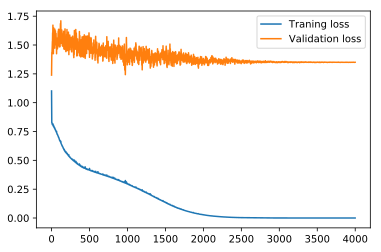

In [25]:
plt.plot(losses['train'], label='Traning loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

## Step 5 检测预测效果

    - plot(x, y)       #plot x, y使用默认的线条样式和颜色
    - plot(x, y, 'bo')    #plot x,y用蓝色圆圈标记
    - plot(y)    #plot y用x作为自变量
    - plot(y, 'r+')      #同上，但是是用红色作为标记

In [20]:
'''

fig, ax = plt.subplots(figsize=(33,5))

mean, std = scaled_feature['cnt']
predictions = network.run(test_features).T*std + mean   #逆向标准化，显示出预测的数据
#使用plot设置两条曲线
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')    #逆向标准化，显示测试集数据

ax.set_xlim(right=len(predictions))  #设置x轴
ax.legend()  #显示图例

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])  #获取指定的时间和日期
dates = dates.apply(lambda d: d.strftime('%b %d'))    #将X轴设置为日期       （ %b是月份 %d是日子 ）
ax.set_xticks(np.arange(len(dates))[12::24])         #设置X轴标签
_ = ax.set_xticklabels(dates[12::24], rotation=35)   #设置X轴标签文字  rotation：显示翻转角度

'''

"\n\nfig, ax = plt.subplots(figsize=(33,5))\n\nmean, std = scaled_feature['cnt']\npredictions = network.run(test_features).T*std + mean   #逆向标准化，显示出预测的数据\n#使用plot设置两条曲线\nax.plot(predictions[0], label='Prediction')\nax.plot((test_targets['cnt']*std + mean).values, label='Data')    #逆向标准化，显示测试集数据\n\nax.set_xlim(right=len(predictions))  #设置x轴\nax.legend()  #显示图例\n\ndates = pd.to_datetime(rides.loc[test_data.index]['dteday'])  #获取指定的时间和日期\ndates = dates.apply(lambda d: d.strftime('%b %d'))    #将X轴设置为日期       （ %b是月份 %d是日子 ）\nax.set_xticks(np.arange(len(dates))[12::24])         #设置X轴标签\n_ = ax.set_xticklabels(dates[12::24], rotation=35)   #设置X轴标签文字  rotation：显示翻转角度\n\n"

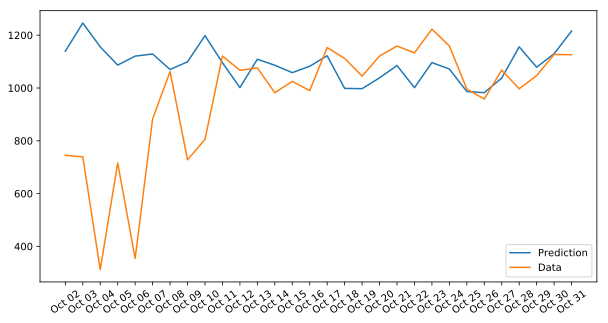

In [26]:
fig, ax = plt.subplots(figsize=(10,5))

mean, std = scaled_feature['cnt']
predictions = network.run(test_features).T*std + mean   #逆向标准化，显示出预测的数据
#使用plot设置两条曲线
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')  

#ax.set_xlim(right=len(predictions))  #设置x轴
ax.legend()  #显示图例

dates = pd.to_datetime(rides.loc[test_data.index]['dteday'])  #获取指定的时间和日期
dates = dates.apply(lambda d: d.strftime('%b %d'))    #将X轴设置为日期       （ %b是月份 %d是日子 ）
ax.set_xticks(np.arange(len(dates))[::])         #设置X轴标签
_ = ax.set_xticklabels(dates[::], rotation=35)   #设置X轴标签文字  rotation：显示翻转角度